In [ ]:
'''
This notebook analyzes splicing and cleavage using b-globin targeted LRS data and plots panels for Figure 6 and S7
'''

In [1]:
import os
import re
import glob

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import mygene
import scipy

from plotnine import *
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # export pdfs with editable font types in Illustrator

In [2]:
# Links to input data: BED12 files that have been filtered to remove splicing intermediates
dataFiles = [
    '../1_filter_data/targeted_HBB_data/HBB1_GLOBE_polyAfiltered_softclipped_filled_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/targeted_HBB_data/HBB2_GLOBE_polyAfiltered_softclipped_filled_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/targeted_HBB_data/HBB3_GLOBE_polyAfiltered_softclipped_filled_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/targeted_HBB_data/IVS1_GLOBE_polyAfiltered_softclipped_filled_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/targeted_HBB_data/IVS2_GLOBE_polyAfiltered_softclipped_filled_sorted_unique_no_splicing_int.bed',
    '../1_filter_data/targeted_HBB_data/IVS3_GLOBE_polyAfiltered_softclipped_filled_sorted_unique_no_splicing_int.bed',
     ]

intermediate_dataFiles = [
    '../1_filter_data/targeted_HBB_data/HBB1_GLOBE_polyAfiltered_softclipped_filled_sorted_unique_splicing_int.bed',
    '../1_filter_data/targeted_HBB_data/HBB2_GLOBE_polyAfiltered_softclipped_filled_sorted_unique_splicing_int.bed',
    '../1_filter_data/targeted_HBB_data/HBB3_GLOBE_polyAfiltered_softclipped_filled_sorted_unique_splicing_int.bed',
    '../1_filter_data/targeted_HBB_data/IVS1_GLOBE_polyAfiltered_softclipped_filled_sorted_unique_splicing_int.bed',
    '../1_filter_data/targeted_HBB_data/IVS2_GLOBE_polyAfiltered_softclipped_filled_sorted_unique_splicing_int.bed',
    '../1_filter_data/targeted_HBB_data/IVS3_GLOBE_polyAfiltered_softclipped_filled_sorted_unique_splicing_int.bed',
]

In [3]:
# Define a function that gets the splicing and cleavage status for each read from BED12 file
# Output is df of reads in BED12 format plus information about splicing status for each read
def get_splicing_cleavage_status(file):
    f = open(file)
    output = [] # create an empty list for output to be added to
    
    sample_string = file.split('/')[3] # get information from filename to be added to output dataframe
    replicate = sample_string.split('_')[0]
    genome = sample_string.split('_')[1]
    
    # set coordinates of gene features to be checked in each read
    intron_1_GLOBE_canoncial = (5182, 5312)
    intron_1_GLOBE_cryptic = (5201, 5312)
    intron_2_GLOBE = (4702, 4959)
    intron_1_mm10 = (103827670, 103827783)
    intron_2_mm10 = (103826793, 103827447)
    gene_body_mm10 = range(103826531,103827928)
    gene_body_GLOBE = range(4439,5455)
    PAS_GLOBE = 4439
    PAS_mm10 = 103826531
    
    for line in f:
        col = line.strip().split('\t')
        readName = col[3]
        n_blocks = int(col[9]) # get number of blocks to use as counter
        exon_size_list = col[10] # gets list of block (exon) sizes from BED12 file
        readStart = int(col[1])
        readEnd = int(col[2])
        exon_size = exon_size_list.split(",") # for getting last exon size
        blockStarts = col[11].split(",")
        blockSizes = col[10].split(",")
        junclist = [] # create an empty list for coordinates of junctions in each read

        if genome == 'GLOBE':
            # generate a list of splice junctions for each read called junclist
            for i in range(1,n_blocks):
                juncStart = int(readStart) + int(blockSizes[i-1]) + int(blockStarts[i-1])
                juncEnd = int(readStart) + int(blockStarts[i])
                junc = (juncStart,juncEnd)
                junclist.append(junc)
            
            # check if canoncial or cryptic intron 1 splice junction is in the read and assign counter for each (1 is spliced, 0 is unspliced)
            if readStart < 5183 and readEnd > 5313: # if read covers intron 1 then assign splicing status
                if intron_1_GLOBE_canoncial in junclist:
                    int1_spliced = 1
                    int1_used = 'canonical'
                elif intron_1_GLOBE_cryptic in junclist:
                    int1_spliced = 1
                    int1_used = 'cryptic'
                else:
                    int1_spliced = 0
                    int1_used = np.nan
            else: # if read does not span intron 1 then don't assign splicing status, set to NaN
                int1_spliced = np.nan
                int1_used = np.nan
                
            # check if intron 2 splice junction is in the read and assign a counter (1 is spliced, 0 is unspliced) 
            if readStart < 4703 and readEnd > 4960: # if read covers intron 2 then assign splicing status
                if intron_2_GLOBE in junclist:
                    int2_spliced = 1
                else:
                    int2_spliced = 0
            else: # if read does not span intron 2 then don't assign splicing status, set to NaN
                int2_spliced = np.nan
                
            # check if read is cleaved or not and assign a counter (1 is cleaved, 0 is uncleaved)
            if readEnd in gene_body_GLOBE and readStart < (PAS_GLOBE - 50): # check if read starts within gene body and ends more than 50 nt downstream of PAS
                uncleaved = 1
            else:
                uncleaved = 0

            output.append([col[0], col[1], col[2], col[3], col[4], col[5], col[6], col[7], col[8], col[9], col[10], col[11], replicate, genome, int1_spliced, int1_used, int2_spliced, uncleaved])

            
        if genome == 'mm10':
            # generate a list of splice junctions for each read called junclist
            for i in range(1,n_blocks):
                juncStart = int(readStart) + int(blockSizes[i-1]) + int(blockStarts[i-1])
                juncEnd = int(readStart) + int(blockStarts[i])
                junc = (juncStart,juncEnd)
                junclist.append(junc)
            
            # check if intron 1 splice junction is in the read and assign counter for each (1 is spliced, 0 is unspliced)
            if readStart < 103827671 and readEnd > 103827784: # if read covers intron 1 then assign splicing status
                if intron_1_mm10 in junclist:
                    int1_spliced = 1
                    int1_used = 'canonical'
                else:
                    int1_spliced = 0
                    int1_used = np.nan
            else: # if read does not span intron 1 then don't assign splicing status, set to NaN
                int1_spliced = np.nan
                int1_used = np.nan
                
            # check if intron 2 splice junction is in the read and assign a counter (1 is spliced, 0 is unspliced) 
            if readStart < 103826794 and readEnd > 103827448: # if read covers intron 2 then assign splicing status# check if intron 2 splice junction is in the read and assign a counter (1 is spliced, 0 is unspliced) 
                if intron_2_mm10 in junclist:
                    int2_spliced = 1
                else:
                    int2_spliced = 0
            else: # if read does not span intron 2 then don't assign splicing status, set to NaN
                int2_spliced = np.nan
                
            # check if read is cleaved or not (whether 5' end is in gene body and 3' end is more than 50 nt downstream of PAS) and assign a counter (1 is cleaved, 0 is uncleaved)
            if readEnd in gene_body_mm10 and readStart < (PAS_mm10 - 50):
                uncleaved = 1
            else:
                uncleaved = 0

            output.append([col[0], col[1], col[2], col[3], col[4], col[5], col[6], col[7], col[8], col[9], col[10], col[11], replicate, genome, int1_spliced, int1_used, int2_spliced, uncleaved])


    df = pd.DataFrame(output, columns=['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'replicate', 'genome', 'int1_spliced', 'int1_used', 'int2_spliced', 'uncleaved'])
    return df

In [10]:
# get splicing and cleavage status for each read from input BED12 data
# arrange output df and save as separate BED12 files to use with bedtools intersect
df_list2 = []
for file in dataFiles:
    df_list2.append(get_splicing_cleavage_status(file))
a = pd.concat(df_list2)

# add new column 'condition' which combines replicate and splice site info
a['condition'] = pd.np.where(a['replicate'].str.contains("HBB"), "WT", "IVS-110") # group by HBB or IVS string in repliate name

# assign each read into a category as described below
a.loc[((a['int1_spliced'] == 0) & (a['int2_spliced'] == 0)), 'splicing_category'] = 'none'
a.loc[((a['int1_spliced'] == 1) & (a['int2_spliced'] == 0)), 'splicing_category'] = 'one'
a.loc[((a['int1_spliced'] == 0) & (a['int2_spliced'] == 1)), 'splicing_category'] = 'two'
a.loc[((a['int1_spliced'] == 1) & (a['int2_spliced'] == 1)), 'splicing_category'] = 'both'
a = a.dropna(subset=['splicing_category']) # drop any reads with NaN as splicing category (since these reads don't overlap both introns and cannot be classified)
g = a.loc[a['genome'] == 'GLOBE'] # get only GLOBE reads

hbb1_none = g.loc[(g['replicate'] == 'HBB1') & (g['splicing_category'] == 'none')]
hbb1_one = g.loc[(g['replicate'] == 'HBB1') & (g['splicing_category'] == 'one')]
hbb1_two = g.loc[(g['replicate'] == 'HBB1') & (g['splicing_category'] == 'two')]
hbb1_both = g.loc[(g['replicate'] == 'HBB1') & (g['splicing_category'] == 'both')]

hbb2_none = g.loc[(g['replicate'] == 'HBB2') & (g['splicing_category'] == 'none')]
hbb2_one = g.loc[(g['replicate'] == 'HBB2') & (g['splicing_category'] == 'one')]
hbb2_two = g.loc[(g['replicate'] == 'HBB2') & (g['splicing_category'] == 'two')]
hbb2_both = g.loc[(g['replicate'] == 'HBB2') & (g['splicing_category'] == 'both')]

hbb3_none = g.loc[(g['replicate'] == 'HBB3') & (g['splicing_category'] == 'none')]
hbb3_one = g.loc[(g['replicate'] == 'HBB3') & (g['splicing_category'] == 'one')]
hbb3_two = g.loc[(g['replicate'] == 'HBB3') & (g['splicing_category'] == 'two')]
hbb3_both = g.loc[(g['replicate'] == 'HBB3') & (g['splicing_category'] == 'both')]

ivs1_none = g.loc[(g['replicate'] == 'IVS1') & (g['splicing_category'] == 'none')]
ivs1_one = g.loc[(g['replicate'] == 'IVS1') & (g['splicing_category'] == 'one')]
ivs1_two = g.loc[(g['replicate'] == 'IVS1') & (g['splicing_category'] == 'two')]
ivs1_both = g.loc[(g['replicate'] == 'IVS1') & (g['splicing_category'] == 'both')]

ivs2_none = g.loc[(g['replicate'] == 'IVS2') & (g['splicing_category'] == 'none')]
ivs2_one = g.loc[(g['replicate'] == 'IVS2') & (g['splicing_category'] == 'one')]
ivs2_two = g.loc[(g['replicate'] == 'IVS2') & (g['splicing_category'] == 'two')]
ivs2_both = g.loc[(g['replicate'] == 'IVS2') & (g['splicing_category'] == 'both')]

ivs3_none = g.loc[(g['replicate'] == 'IVS3') & (g['splicing_category'] == 'none')]
ivs3_one = g.loc[(g['replicate'] == 'IVS3') & (g['splicing_category'] == 'one')]
ivs3_two = g.loc[(g['replicate'] == 'IVS3') & (g['splicing_category'] == 'two')]
ivs3_both = g.loc[(g['replicate'] == 'IVS3') & (g['splicing_category'] == 'both')]


# write out a files of just GLOBE reads with classified splicing status in BED12 format to use for bedtools coverage
cov_file_cols = ['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'replicate', 'splicing_category']

hbb1_none[cov_file_cols].to_csv('HBB1_none.bed', index = False, sep = '\t', header = False)
hbb1_one[cov_file_cols].to_csv('HBB1_one.bed', index = False, sep = '\t', header = False)
hbb1_two[cov_file_cols].to_csv('HBB1_two.bed', index = False, sep = '\t', header = False)
hbb1_both[cov_file_cols].to_csv('HBB1_both.bed', index = False, sep = '\t', header = False)

hbb2_none[cov_file_cols].to_csv('HBB2_none.bed', index = False, sep = '\t', header = False)
hbb2_one[cov_file_cols].to_csv('HBB2_one.bed', index = False, sep = '\t', header = False)
hbb2_two[cov_file_cols].to_csv('HBB2_two.bed', index = False, sep = '\t', header = False)
hbb2_both[cov_file_cols].to_csv('HBB2_both.bed', index = False, sep = '\t', header = False)

hbb3_none[cov_file_cols].to_csv('HBB3_none.bed', index = False, sep = '\t', header = False)
hbb3_one[cov_file_cols].to_csv('HBB3_one.bed', index = False, sep = '\t', header = False)
hbb3_two[cov_file_cols].to_csv('HBB3_two.bed', index = False, sep = '\t', header = False)
hbb3_both[cov_file_cols].to_csv('HBB3_both.bed', index = False, sep = '\t', header = False)

ivs1_none[cov_file_cols].to_csv('IVS1_none.bed', index = False, sep = '\t', header = False)
ivs1_one[cov_file_cols].to_csv('IVS1_one.bed', index = False, sep = '\t', header = False)
ivs1_two[cov_file_cols].to_csv('IVS1_two.bed', index = False, sep = '\t', header = False)
ivs1_both[cov_file_cols].to_csv('IVS1_both.bed', index = False, sep = '\t', header = False)

ivs2_none[cov_file_cols].to_csv('IVS2_none.bed', index = False, sep = '\t', header = False)
ivs2_one[cov_file_cols].to_csv('IVS2_one.bed', index = False, sep = '\t', header = False)
ivs2_two[cov_file_cols].to_csv('IVS2_two.bed', index = False, sep = '\t', header = False)
ivs2_both[cov_file_cols].to_csv('IVS2_both.bed', index = False, sep = '\t', header = False)

ivs3_none[cov_file_cols].to_csv('IVS3_none.bed', index = False, sep = '\t', header = False)
ivs3_one[cov_file_cols].to_csv('IVS3_one.bed', index = False, sep = '\t', header = False)
ivs3_two[cov_file_cols].to_csv('IVS3_two.bed', index = False, sep = '\t', header = False)
ivs3_both[cov_file_cols].to_csv('IVS3_both.bed', index = False, sep = '\t', header = False)

In [ ]:
# Use bedtools to calculate coverage over the HBB gene region (IN A TERMINAL WINDOW)
################################################################################################################
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b HBB1_none.bed > HBB1_GLOBE_none_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b HBB1_one.bed > HBB1_GLOBE_one_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b HBB1_two.bed > HBB1_GLOBE_two_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b HBB1_both.bed > HBB1_GLOBE_both_spliced_cov.txt

# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b HBB2_none.bed > HBB2_GLOBE_none_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b HBB2_one.bed > HBB2_GLOBE_one_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b HBB2_two.bed > HBB2_GLOBE_two_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b HBB2_both.bed > HBB2_GLOBE_both_spliced_cov.txt

# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b HBB3_none.bed > HBB3_GLOBE_none_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b HBB3_one.bed > HBB3_GLOBE_one_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b HBB3_two.bed > HBB3_GLOBE_two_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b HBB3_both.bed > HBB3_GLOBE_both_spliced_cov.txt

# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b IVS1_none.bed > IVS1_GLOBE_none_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b IVS1_one.bed > IVS1_GLOBE_one_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b IVS1_two.bed > IVS1_GLOBE_two_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b IVS1_both.bed > IVS1_GLOBE_both_spliced_cov.txt

# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b IVS2_none.bed > IVS2_GLOBE_none_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b IVS2_one.bed > IVS2_GLOBE_one_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b IVS2_two.bed > IVS2_GLOBE_two_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b IVS2_both.bed > IVS2_GLOBE_both_spliced_cov.txt

# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b IVS3_none.bed > IVS3_GLOBE_none_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b IVS3_one.bed > IVS3_GLOBE_one_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b IVS3_two.bed > IVS3_GLOBE_two_spliced_cov.txt
# bedtools coverage -s -d -a ../annotation_files/GLOBE_genome.bed -b IVS3_both.bed > IVS3_GLOBE_both_spliced_cov.txt
################################################################################################################

In [11]:
# Define a function to read in output of bedtools coverage, rearrange columns and compute coverage in bins over a TES window
def get_coverage(file):
    filestring = file.split('/')[-1].split('_')
    ID = '_'.join(filestring) # get sample ID from file name
    rep = ID.split('_')[0]
    genome = ID.split('_')[1]
    splicing_status = '_'.join(ID.split('_')[2:4])
    
    f = pd.read_csv(file, sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'position', 'count'])
    f['rel_position'] = range(4438,-4561,-1) # add relative position around PAS (descending order so it flips the orientation since it is on the minus strand)
    # GLOBE PAS is at nucleotide position 4439, so normalize to 100 nt before this at position 4338
    norm_val = f.loc[f['rel_position'] == -100, 'count'].iloc[0] # get the coverage at nucleotide position 100 upstream of the PAS
    f['norm_val'] = norm_val
    f['norm_count'] = f['count']/f['norm_val']
    f['replicate'] = rep
    f['genome'] = genome
    f['splicing_status'] = splicing_status

    return f # return dataframe with position around TES ('normalized_count') and relative position around TES ('rel_position')

In [12]:
cov_df_list = []
for file in glob.glob('./*_cov.txt'):
    cov_df_single = get_coverage(file)
    cov_df_list.append(cov_df_single)
cov_df = pd.concat(cov_df_list)

# add new column 'condition' which combines replicate and splice site info
cov_df['condition'] = pd.np.where(cov_df['replicate'].str.contains("HBB"), "WT", "IVS-110") # group by HBB or IVS string in repliate name
cov_df_means = cov_df.groupby(['condition', 'splicing_status', 'rel_position']).mean()['norm_count']
cov_df_means = cov_df_means.reset_index()
cov_df_means.columns = ['condition', 'splicing_status', 'rel_position', 'mean_cov']

cov_df_errors = cov_df.groupby(['condition', 'splicing_status', 'rel_position']).sem()['norm_count']
cov_df_errors = cov_df_errors.reset_index()
cov_df_errors.columns = ['condition', 'splicing_status', 'rel_position', 'error_cov']

cov_df_merged = pd.merge(cov_df_means, cov_df_errors, left_on = ['condition', 'splicing_status', 'rel_position'], right_on = ['condition', 'splicing_status', 'rel_position'], how = 'inner')
cov_df_merged['error_max'] = cov_df_merged['mean_cov'] + cov_df_merged['error_cov']
cov_df_merged['error_min'] = cov_df_merged['mean_cov'] - cov_df_merged['error_cov']

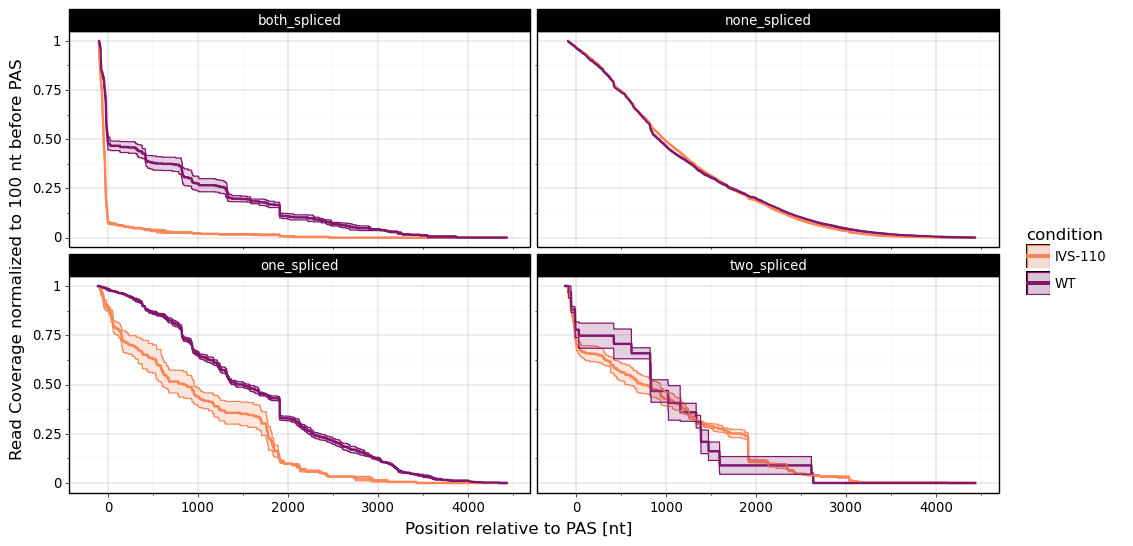

<ggplot: (8773341172733)>

In [13]:
my_colours = ['#FA8657', '#81176D']
plt_PAS_coverage = (ggplot(
      data=cov_df_merged, mapping = aes(x='rel_position', y='mean_cov', colour='condition'))+
      geom_line(size=1) +
      geom_ribbon(aes(ymin='error_min', ymax='error_max', fill = 'condition'), alpha=0.2) +
      facet_wrap(facets = 'splicing_status') +
      scale_colour_manual(values = my_colours) + 
      scale_fill_manual(values = my_colours) + 
      theme_linedraw(base_size = 12) +
      theme(figure_size = (12,6)) +
      xlab('Position relative to PAS [nt]') +
      ylim(0,1) +
      xlim(-200,4461) +
#       xlim(-100,200) +
      ylab('Read Coverage normalized to 100 nt before PAS'))
plt_PAS_coverage

In [14]:
# count the total number of reads that are in each splicing category for each replicate
read_count = a.groupby(['replicate', 'genome', 'condition', 'splicing_category']).count()['name']
read_count = read_count.reset_index()
read_count.columns = ['replicate', 'genome', 'condition', 'splicing_category', 'read_count']
# count the number of uncleaved reads that are in each splicing category for each replicate
uncleaved_count = a.groupby(['replicate', 'genome', 'condition', 'splicing_category']).sum()['uncleaved'] # count number of uncleaved reads in each condition
uncleaved_count = uncleaved_count.reset_index()

# combine into one df with info about total and uncleaved read counts for all replicates
data = pd.merge(read_count, uncleaved_count, left_on = ['replicate', 'genome', 'condition', 'splicing_category'], right_on = ['replicate', 'genome', 'condition', 'splicing_category'], how = 'inner')
totals = data.groupby(['genome', 'replicate', 'condition']).sum()['read_count']
totals = totals.reset_index()
totals.columns = ['genome', 'replicate', 'condition', 'read_total_per_rep']
data_with_totals = pd.merge(data, totals, left_on = ['genome', 'replicate', 'condition'], right_on = ['genome', 'replicate', 'condition'], how = 'left')
data_with_totals['read_frac'] = data_with_totals['read_count']/data_with_totals['read_total_per_rep'] # calculate fraction instead of raw count
# data_with_totals['uncleaved_frac'] = data_with_totals['uncleaved']/data_with_totals['read_count'] # calculate fraction instead of raw count
data_with_totals['uncleaved_frac'] = data_with_totals['uncleaved']/data_with_totals['read_total_per_rep'] # calculate fraction instead of raw count

# now group replicates and calculate mean and standard error
mean_cleavage = data_with_totals.groupby(['genome', 'condition', 'splicing_category']).mean()['uncleaved_frac'] # calculate mean
error_cleavage = data_with_totals.groupby(['genome', 'condition', 'splicing_category']).sem()['uncleaved_frac'] # calculate standard error of the mean
mean_reads = data_with_totals.groupby(['genome', 'condition', 'splicing_category']).mean()['read_frac'] # calculate mean
error_reads = data_with_totals.groupby(['genome', 'condition', 'splicing_category']).sem()['read_frac'] # calculate standard error of the mean

cat_type = CategoricalDtype(categories=['both', 'two', 'one', 'none'], ordered=True) # turn splicing_category column into a category variable in order to control order of plotting
# cat_type = CategoricalDtype(categories=['all_unspliced', 'partially_spliced', 'all_spliced'], ordered=True) # turn splicing_category column into a category variable in order to control order of plotting

cleavage = pd.concat([mean_cleavage, error_cleavage], axis = 1)
cleavage.columns = ['mean', 'error']
cleavage['upper'] = cleavage['mean'] + cleavage['error']
cleavage['lower'] = cleavage['mean'] - cleavage['error']
cleavage = cleavage.reset_index()
cleavage['splicing_category'] = cleavage['splicing_category'].astype(cat_type)

splicing = pd.concat([mean_reads, error_reads], axis = 1)
splicing.columns = ['mean', 'error']
splicing['upper'] = splicing['mean'] + splicing['error']
splicing['lower'] = splicing['mean'] - splicing['error']
splicing = splicing.reset_index()
splicing['splicing_category'] = splicing['splicing_category'].astype(cat_type)

globe_splicing = splicing.loc[splicing['genome'] == 'GLOBE']
globe_cleavage = cleavage.loc[cleavage['genome'] == 'GLOBE']

Ttest_indResult(statistic=18.13219277167805, pvalue=5.4399460782813305e-05)
Ttest_indResult(statistic=31.78654965326652, pvalue=5.838719043869423e-06)
Ttest_indResult(statistic=-17.62939052752895, pvalue=6.0805556040276693e-05)
Ttest_indResult(statistic=-15.9360885958613, pvalue=9.063768933329084e-05)


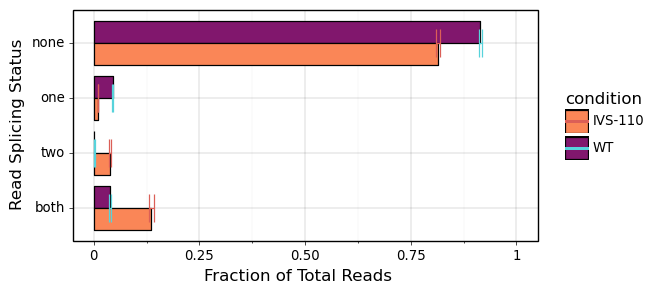

<ggplot: (8773347952277)>

In [16]:
# Plot the fraction of reads that are in each splicing category for WT and IVS
my_colours = ['#FA8657', '#81176D']

plot_read_fraction = (ggplot
     (data = globe_splicing, mapping = aes(x = 'splicing_category', y = 'mean', fill = 'condition')) + 
      geom_bar(stat = 'identity', position = 'dodge', colour = 'black', width = 0.8) +
#       facet_wrap(facets = 'genome') +
      geom_errorbar(aes(x = 'splicing_category', ymax = 'upper', ymin = 'lower', colour = 'condition')) +
      scale_fill_manual(values = my_colours) +
      xlab('Read Splicing Status') +
      ylab('Fraction of Total Reads') +
      coord_flip() +
      ylim(0,1) +
      theme_linedraw(base_size = 12) +
      theme(figure_size = (6,3))
      )

# Calculate unpaired t-test statistic for each HBB/IVS comparison using three replicates
wt_none = data_with_totals.loc[(data_with_totals['genome'] == 'GLOBE') & (data_with_totals['splicing_category'] == 'none') & (data_with_totals['condition'] == 'WT')]['read_frac']
wt_one = data_with_totals.loc[(data_with_totals['genome'] == 'GLOBE') & (data_with_totals['splicing_category'] == 'one') & (data_with_totals['condition'] == 'WT')]['read_frac']
wt_two = data_with_totals.loc[(data_with_totals['genome'] == 'GLOBE') & (data_with_totals['splicing_category'] == 'two') & (data_with_totals['condition'] == 'WT')]['read_frac']
wt_both = data_with_totals.loc[(data_with_totals['genome'] == 'GLOBE') & (data_with_totals['splicing_category'] == 'both') & (data_with_totals['condition'] == 'WT')]['read_frac']

ivs_none = data_with_totals.loc[(data_with_totals['genome'] == 'GLOBE') & (data_with_totals['splicing_category'] == 'none') & (data_with_totals['condition'] == 'IVS-110')]['read_frac']
ivs_one = data_with_totals.loc[(data_with_totals['genome'] == 'GLOBE') & (data_with_totals['splicing_category'] == 'one') & (data_with_totals['condition'] == 'IVS-110')]['read_frac']
ivs_two = data_with_totals.loc[(data_with_totals['genome'] == 'GLOBE') & (data_with_totals['splicing_category'] == 'two') & (data_with_totals['condition'] == 'IVS-110')]['read_frac']
ivs_both = data_with_totals.loc[(data_with_totals['genome'] == 'GLOBE') & (data_with_totals['splicing_category'] == 'both') & (data_with_totals['condition'] == 'IVS-110')]['read_frac']

ttest_none = scipy.stats.ttest_ind(wt_none, ivs_none)
ttest_one = scipy.stats.ttest_ind(wt_one, ivs_one)
ttest_two = scipy.stats.ttest_ind(wt_two, ivs_two)
ttest_both = scipy.stats.ttest_ind(wt_both, ivs_both)

print(ttest_none)
print(ttest_one)
print(ttest_two)
print(ttest_both)

plot_read_fraction

In [26]:
# count total number of reads in each condition
wt_total = data_with_totals.loc[data_with_totals['condition'] == 'WT']
ivs_total = data_with_totals.loc[data_with_totals['condition'] == 'IVS-110']
print('Total number of reads in WT: ' + str(wt_total['read_count'].sum()))
print('Total number of reads in WT: ' + str(ivs_total['read_count'].sum()))

Total number of reads in WT: 20395
Total number of reads in WT: 26244


In [84]:
# Define a function that counts the number of intermediates at each intron from filtered intermediate BED files
def count_intermediates(BEDfile):
    sample = file.split('/')[-1].split('_')[0]
    genome = file.split('/')[-1].split('_')[1] 
    
    f = pd.read_csv(BEDfile, sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts'])
    counts = f['start'].value_counts().rename_axis('int_coord').reset_index(name='counts')
    counts['sample'] = sample
    counts['genome'] = genome

    return counts

In [85]:
# Count the number of splicing intermediates for each sample - just count the number of reads that were filtered in this filtering step and saved as an output file
int_counts_dflist = []
for file in intermediate_dataFiles:
    int_count_df = count_intermediates(file)
    int_counts_dflist.append(int_count_df)
int_counts = pd.concat(int_counts_dflist)
    
no_splicing_int_count = []
for file in dataFiles:
    count = len(open(file).readlines())
    no_splicing_int_count.append(count)

samples = []
for file in dataFiles:
    sample = file.split('/')[-1].split('_')[0]
    samples.append(sample)
    
genomes = []
for file in dataFiles:
    genome = file.split('/')[-1].split('_')[1] 
    genomes.append(genome)

all_counts = pd.DataFrame(list(zip(samples, genomes, no_splicing_int_count)), 
                        columns =['sample', 'genome', 'non_intermediates_count'])

In [124]:
intermediates_df = pd.merge(int_counts, all_counts, left_on = 'sample', right_on = 'sample', how = 'left')
intermediates_df['total_counts'] = intermediates_df['counts'] + intermediates_df['non_intermediates_count']
intermediates_df['fraction_intermediates'] = intermediates_df['counts']/intermediates_df['total_counts']
intermediates_df['condition'] = pd.np.where(intermediates_df['sample'].str.contains("HBB"), "WT", "IVS-110") # group by HBB or IVS string in repliate name

cat = CategoricalDtype(categories=['WT', 'IVS-110'], ordered=True) # turn category column into a category variable in order to control order of plotting
intermediates_df['condition'] = intermediates_df['condition'].astype(cat)

intermediates_df['intron'] = pd.np.where(intermediates_df['int_coord'] == 5312, "intron_1", "intron_2") # group by HBB or IVS string in repliate name

int_counts_mean = intermediates_df.groupby(['condition', 'intron']).mean()['fraction_intermediates']
int_counts_error = intermediates_df.groupby(['condition', 'intron']).sem()['fraction_intermediates']
int_counts_grouped = pd.concat([int_counts_mean, int_counts_error], axis = 1)
int_counts_grouped = int_counts_grouped.reset_index()
int_counts_grouped.columns = ['condition', 'intron', 'mean', 'error']
int_counts_grouped['upper'] = int_counts_grouped['mean'] + int_counts_grouped['error']
int_counts_grouped['lower'] = int_counts_grouped['mean'] - int_counts_grouped['error']

Ttest_indResult(statistic=12.377051252915454, pvalue=0.000244914858871711)
Ttest_indResult(statistic=5.8024149554176825, pvalue=0.004387998345230135)


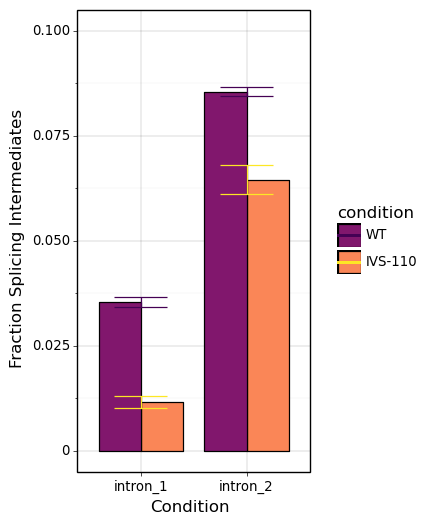

<ggplot: (8777613285309)>

In [128]:
my_colours = ['#81176D','#FA8657']

plot_int_fraction = (ggplot
     (data = int_counts_grouped, mapping = aes(x = 'intron', y = 'mean', fill = 'condition')) + 
      geom_bar(stat = 'identity', position = 'dodge', colour = 'black', width = 0.8) +
#       facet_wrap(facets = 'genome') +
      geom_errorbar(aes(x = 'intron', ymax = 'upper', ymin = 'lower', colour = 'condition')) +
      scale_fill_manual(values = my_colours) +
      xlab('Condition') +
      ylab('Fraction Splicing Intermediates') +
#       coord_flip() +
      ylim(0,.1) +
      theme_linedraw(base_size = 12) +
      theme(figure_size = (3,6))
      )

# Calculate unpaired t-test statistic for each HBB/IVS comparison using three replicates
wt_int1 = intermediates_df.loc[(intermediates_df['intron'] == 'intron_1') & (intermediates_df['condition'] == 'WT')]['fraction_intermediates']
ivs_int1 = intermediates_df.loc[(intermediates_df['intron'] == 'intron_1') & (intermediates_df['condition'] == 'IVS-110')]['fraction_intermediates']
wt_int2 = intermediates_df.loc[(intermediates_df['intron'] == 'intron_2') & (intermediates_df['condition'] == 'WT')]['fraction_intermediates']
ivs_int2 = intermediates_df.loc[(intermediates_df['intron'] == 'intron_2') & (intermediates_df['condition'] == 'IVS-110')]['fraction_intermediates']

ttest_int1 = scipy.stats.ttest_ind(wt_int1, ivs_int1)
ttest_int2 = scipy.stats.ttest_ind(wt_int2, ivs_int2)

print(ttest_int1)
print(ttest_int2)
plot_int_fraction

In [129]:
# Save outputs
plot_read_fraction.save('plot_read_fraction.pdf')
plt_PAS_coverage.save('plt_PAS_coverage.pdf')
plot_int_fraction.save('plot_int_fraction.pdf')